In [ ]:
import pandas as pd
from sklearn.linear_model import GammaRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_rows', 500)


## Loading data

In [ ]:
path2021 = "../data/uefa-data/processed/2021_"
path2020 = "../data/uefa-data/processed/2020_"

playerStats = pd.read_csv(path2021 + "player_stats.csv")
defense = pd.read_csv(path2021 + "defense.csv")
goalkeeping = pd.read_csv(path2021 + "goalkeeping.csv")
passing = pd.read_csv(path2021 + "passing.csv")
shooting = pd.read_csv(path2021 + "shooting.csv")
mv2020 = pd.read_csv(path2020+ "mv.csv")


defense = playerStats.merge(defense, on = "Player")
goalkeeping = playerStats.merge(goalkeeping, on = "Player")
passing = playerStats.merge(passing, on = "Player")
shooting = playerStats.merge(shooting, on = "Player")

path = "../data/processed-data/"


raritaDf = pd.read_csv(path + "l_defense_clean.csv", index_col = 0)
raritaPs = pd.read_csv(path + "l_passing_clean.csv", index_col = 0)
raritaGk = pd.read_csv(path + "l_goalkeeping_clean.csv", index_col = 0)
raritaSh = pd.read_csv(path + "l_shooting_clean.csv", index_col = 0)
salary2020 = pd.read_csv(path + "salary_2020.csv", index_col = 0)
salary2021 = pd.read_csv(path + "salary_2021.csv", index_col = 0)

raritaPlayerStats = raritaDf[["Player", "Squad","DF", "GK", "MF", "FW"]]



## Data exploration

In [ ]:
defense.dropna()[['Player', 'Age', '90s', 'Tack Tkl',
       'Tack TklW', 'Tack Def 3rd', 'Tack Mid 3rd', 'Tack Att 3rd', 'Vs D Tkl',
       'Vs D Att', 'Vs D Tkl%', 'Vs D Past', 'Pres Press', 'Pres Succ',
       'Pres %', 'Pres Def 3rd', 'Pres Mid 3rd', 'Pres Att 3rd', 'Bloc Blocks',
       'Bloc Sh', 'Bloc ShSv', 'Bloc Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']].hist(figsize=(10,10))
goalkeeping.drop(columns = ["GK", "MF", "DF", "FW"]).hist(figsize=(10,10))
passing.drop(columns = ["GK", "MF", "DF", "FW"]).dropna().hist(figsize=(10,10))
shooting.drop(columns = ["GK", "MF", "DF", "FW"]).hist(figsize=(10,10))

defense.to_csv("df.csv")

def plotFeatures(data): 
    X = data.iloc[:,8:]  #independent columns
    y = data.iloc[:,4]    #target column i.e price range
    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(method = "kendall"),annot=True,cmap="RdYlGn")

# diagnostic plots

#salary2020.hist(column = "Annualized Salary", bins = 20)
#salary2021.hist(column = "Annualized Salary", bins = 20)

#plotFeatures(defense)
#plotFeatures(goalkeeping)
#plotFeatures(passing)
#plotFeatures(shooting)

## Data cleaning

In [ ]:

# These are all the 'important' features from visually inspecting the correlation heatmap
df = defense.loc[defense["DF"] == 1]
df = df[["mv",  "Age", "90s", "Tack Tkl", "Tack TklW", "Tack Mid 3rd", "Tack Att 3rd", "Vs D Tkl", "Vs D Past", "Pres Succ", "Pres Mid 3rd", "Bloc Sh", "Bloc Pass", "Int"]]

sh = shooting.loc[shooting["FW"] == 1]
sh = sh[["mv",  "Age", "90s", "Gls", "Stan Sh", "Stan SoT", "Stan G/Sh", "Stan FK", "Perf PK", "Perf PKatt", "Expe xG", "Expe npxG", "Expe npxG/Sh"]]

gk = goalkeeping.loc[goalkeeping["GK"] == 1]
gk = gk[["mv", "Age", "90s", "Play MP", "Play Starts",  "Perf GA", "Perf SoTA", "W", "Perf CS", "Perf CS%", "Pena PKA"]]

ps = passing.loc[passing["MF"] == 1]
ps = ps[["mv", "Age", "90s", "Tota Cmp", "Tota Att", "Tota TotDist", "Shor Cmp", "Shor Att", "Long Cmp%", "Ast", "xA", "KP", "1/3", "PPA", "CrsPA", "Prog"]]
ps["Tota TotDist"] = ps["Tota TotDist"]/100

def remove_empty_rows(df: pd.DataFrame):
    # threshold for zero
    threshold = 0.1

    num = len(df.columns) - 3

    for i, row in df.iterrows():
        count = 0
        for j in row[3:]:
            if ((j < threshold or pd.isna(j))):
                count += 1

        if (count / num > 0.8):
            df = df.drop(i)
    return df;

sh = remove_empty_rows(sh)
df = remove_empty_rows(df)
ps = remove_empty_rows(ps)
gk = remove_empty_rows(gk)

df = df.dropna()
ps = ps.dropna()
sh = sh.dropna()
gk = gk.dropna()

In [ ]:
raritaDf = raritaDf.loc[raritaDf["Year"] == 2021]
raritaSh = raritaSh.loc[raritaSh["Year"] == 2021]
raritaGk = raritaGk.loc[raritaGk["Year"] == 2021]
raritaPs = raritaPs.loc[raritaPs["Year"] == 2021]

raritaDf = raritaDf.loc[raritaDf["DF"] == 1]
raritaDf = raritaDf[["Player","Squad","Age", "90s", "Tackles Tkl", "Tackles TklW", "Tackles Mid 3rd", "Tackles Att 3rd", "Vs Dribbles Tkl", "Vs Dribbles Past", "Pressures Succ", "Pressures Mid 3rd", 'Blocks Sh', "Blocks Pass", "Int"]]

raritaSh = raritaSh.loc[raritaSh["FW"] == 1]
raritaSh = raritaSh[["Player","Squad","Age", "90s", "Gls", "Standard Sh", "Standard SoT", "Standard G/Sh", "Standard FK", "Performance PK", "Performance PKatt", "Expected xG", "Expected npxG", "Expected npxG/Sh"]]

raritaGk = raritaGk.loc[raritaGk["GK"] == 1]
raritaGk = raritaGk[["Player","Squad","Age", "Playing Time 90s", "Playing Time MP", "Playing Time Starts",  "Performance GA", "Performance SoTA", "W", "Performance CS", "Performance CS%", "Penalty Kicks PKA"]]
raritaGk = raritaGk.rename(columns={"Playing Time 90s": "90s"})

raritaPs = raritaPs.loc[raritaPs["MF"] == 1]
raritaPs = raritaPs[["Player","Squad", "Age", "90s", "Total Cmp", "Total Att", "Total TotDist", "Short Cmp", "Short Att", "Long Cmp%", "Ast", "xA", "KP", "1/3", "PPA", "CrsPA", "Prog", "League"]]
raritaPs["Total TotDist"] = raritaPs["Total TotDist"]/100


# process all negatives
# from this we can see there's no negative values beyond -0.1
# might be a reasonable assumption to convert these all to 0
for i, s in raritaDf.drop(columns = ["Player","Squad"]).iteritems():
    print(i, len(s[s < -0])/len(s), len(s[s < -0.1])/len(s))

for i, s in raritaSh.drop(columns = ["Player","Squad"]).iteritems():
    print(i, len(s[s < -0])/len(s), len(s[s < -0.1])/len(s))

for i, s in raritaGk.drop(columns = ["Player","Squad"]).iteritems():
    print(i, len(s[s < -0])/len(s), len(s[s < -0.1])/len(s))

for i, s in raritaPs.drop(columns = ["Player","Squad", "League"]).iteritems():
    print(i, len(s[s < -0])/len(s), len(s[s < -0.1])/len(s))

for i in [raritaDf, raritaGk, raritaSh, raritaPs]:
    num = i._get_numeric_data()
    num[num < 0] = 0


/tmp/ipykernel_222/4287486495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem[convert] = problem[convert].div(abs(problem["90s"]), axis = 0).round(decimals = 2)


            Player                   Nation  FW  MF  DF  GK  \
0         i.winter         Danan Seekeeling   0   0   1   0   
1      p.nakubulwa                  Dosqaly   0   0   1   0   
2       m.mahlangu           Imaar Vircoand   0   0   1   0   
3          i.huber           Lenia Gerdanho   0   0   1   0   
4     a.kobusingye  People's Land of Maneau   0   0   1   0   
...            ...                      ...  ..  ..  ..  ..   
5549         f.gan                   Rarita   0   1   0   0   
5550     c.mitrovi          Southern Ristan   0   1   1   0   
5551     g.mandaza       Greri Landmoslands   1   1   0   0   
5552       h.amade                   Rarita   1   1   0   0   
5553     h.mirembe                   Rarita   1   1   0   0   

                  Squad  Age  Born    90s  ...   Ast    xA  A-xA    KP   1/3  \
0     Fanatical Outlaws   27  1991  13.05  ... -0.04  0.01  0.06 -0.03  1.91   
1     Fanatical Outlaws   22  1997  30.63  ...  0.10  0.08 -0.08  0.04  1.64   
2  

<AxesSubplot:>

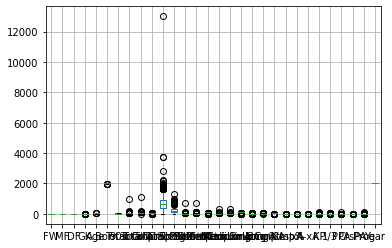

In [64]:
# Converting rows into per 90 values as they seem to not be converted...
path = "../data/processed-data/"
ok = pd.read_csv(path + "l_passing_clean.csv", index_col = 0)

raritaPs = ok.loc[ok["Year"] == 2021]
#raritaPs.boxplot(figsize = (10,10))
problem = raritaPs.loc[(raritaPs["League"] == "D") | (raritaPs["Squad"] == "Black Coyotes") | (raritaPs["Squad"] == "Serious Buffaloes") | (raritaPs["Squad"] == "Strong Oaks")]
convert = problem.columns.difference(["Player", "Nation", "FW","MF","DF","GK","Total Cmp%", "Short Cmp%","Medium Cmp%", "Born","Squad","Age", "90s", "Long Cmp%", "League", "Year"])
problem[convert] = problem[convert].div(abs(problem["90s"]), axis = 0).round(decimals = 2)
raritaPs.loc[(raritaPs["League"] == "D") | (raritaPs["Squad"] == "Black Coyotes") | (raritaPs["Squad"] == "Serious Buffaloes") | (raritaPs["Squad"] == "Strong Oaks")] = problem
ok.loc[ok["Year"] == 2021] = raritaPs

ok.to_csv("ok.csv")
print(ok)
ok.loc[ok["Year"] == 2021].boxplot()



In [ ]:
# join salary for visualisation later
def joinSalary(frame):
    frame = frame.dropna()
    frame = pd.merge(frame, salary2021[["Player Name", "Squad", "Annualized Salary"]], right_on = ["Player Name", "Squad"], left_on=["Player", "Squad"])
    return frame.drop(columns = "Player Name")

raritaPs = joinSalary(raritaPs)
raritaGk = joinSalary(raritaGk)
raritaSh = joinSalary(raritaSh)
raritaDf = joinSalary(raritaDf)



In [ ]:
# add polynomial age predictor
for i in [raritaDf, raritaPs, raritaGk, raritaSh, df, gk, sh, ps]:
    i["Age^2"] = pow(i["Age"],2)


## Building model

In [ ]:


def fitModel(data):
    # make train + test split
    X = data.drop(columns = ["mv"])
    y = data["mv"]

    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 114514)

    model = make_pipeline(StandardScaler(), GammaRegressor(max_iter=1000))
    model.fit(XTrain, yTrain)

    #plt.scatter(x= model.predict(XTrain), y =yTrain-model.predict(XTrain))
    
    yPred = model.predict(XTest)
    return model

# since columns are not named exactly the same (this is fine because they are
# in the same order), sklearn gives a lot of errors
import warnings
warnings.filterwarnings('ignore') 

conversionRate = 1.141

def showFit(model, raritaData):
    predMV  =conversionRate * model.predict(raritaData.dropna().drop(columns = ["Player", "Squad","Annualized Salary"]))

    raritaData = pd.concat([raritaData.dropna(), pd.Series(predMV)], axis = 1)
    raritaData = raritaData.rename({0: "Pred MV"}, axis = "columns")
    raritaData.plot.scatter(x = "Pred MV", y = "Annualized Salary")
    return raritaData.drop(columns = "Annualized Salary")

dfModel = fitModel(df)
shModel = fitModel(sh)
psModel = fitModel(ps)
gkModel = fitModel(gk)

raritaDf = showFit(dfModel, raritaDf)
raritaSh = showFit(shModel, raritaSh)
raritaGk =showFit(gkModel, raritaGk)
raritaPs = showFit(psModel, raritaPs)

raritaDf["Pos"] = "DF"
raritaSh["Pos"] = "FW"
raritaPs["Pos"] = "MF"
raritaGk["Pos"] = "GK"


In [ ]:
print(raritaPlayerStats)
def predict_future_10(model, dataRow):
    future_10 = {}
    for i in range(10):
        dataRow["Age"] = dataRow["Age"] + i + 1
        dataRow["Age^2"] = pow(dataRow["Age"], 2)
        predMV = conversionRate * model.predict(dataRow.dropna().drop(columns = ["Player", "Squad"]))

        future_10["Salary "+ str(i+1)] = predMV

    print(future_10)

for i, s in raritaPlayerStats.iterrows():
    dfPlayers = raritaDf.loc[(raritaDf['Player'] == s["Player"]) & (raritaDf['Squad'] == s["Squad"])]
    shPlayers = raritaSh.loc[(raritaSh['Player'] == s["Player"]) & (raritaSh['Squad'] == s["Squad"])]
    psPlayers = raritaPs.loc[(raritaPs['Player'] == s["Player"]) & (raritaPs['Squad'] == s["Squad"])]
    gkPlayers = raritaGk.loc[(raritaGk['Player'] == s["Player"]) & (raritaGk['Squad'] == s["Squad"])]

    numPosition = s["DF"] + s["GK"] + s["MF"] + s["FW"]
    # player plays more than 1 position, get strongest position
    pos = ""
    
    if (numPosition > 1):
        max_mv = 0
        
        for j in [dfPlayers, shPlayers, gkPlayers, psPlayers]:
            if (j.empty == False and j["Pred MV"] > max_mv):
                max_mv = j["Pred MV"]
                max_pos = j["Pos"]
    else:
        for j in [dfPlayers, shPlayers, gkPlayers, psPlayers]:
            if (j.empty == False):
                pos = j["Pos"]
    print(pos)
    if (pos[0] == "DF"):
        predict_future_10(dfModel, s)
        



            


